# Librerías

In [23]:
!pip install --quiet ultralytics openai-clip opencv-python matplotlib
!pip install opencv-python
!pip install pytesseract opencv-python-headless
!sudo apt-get install tesseract-ocr
!pip install ultralytics
!pip install easyocr

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
tesseract-ocr is already the newest version (4.1.1-2.1build1).
0 upgraded, 0 newly installed, 0 to remove and 87 not upgraded.


In [24]:
from ultralytics.engine.results import Results, Boxes
from sklearn.base import BaseEstimator, TransformerMixin, ClassifierMixin
from sklearn.pipeline import Pipeline
from ultralytics import YOLO
from PIL import Image
import torch, easyocr, cv2, pytesseract, clip, os
import matplotlib.patches as patches
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image

# EasyOCR


In [25]:
#Función auxiliar para extraer el pedazo de imagen dentro del bounding box con un padding determinado y para cambiar labels

def extract_subimage_yolo(image, bbox, padding=0):
    height, width = image.shape[:2]
    x_min, y_min, x_max, y_max = bbox

    x_min = int(x_min) - padding
    y_min = int(y_min) - padding
    x_max = int(x_max) + padding
    y_max = int(y_max) + padding

    x_min = max(x_min, 0)
    y_min = max(y_min, 0)
    x_max = min(x_max, width)
    y_max = min(y_max, height)

    cropped = image[y_min:y_max, x_min:x_max].copy()
    return cropped


def relabel_multiple_results(results_list, new_labels):
    total_detections = sum(len(r.boxes) for r in results_list)
    if total_detections != len(new_labels):
        raise ValueError(f"{len(new_labels)} labels provided for {total_detections} detections.")

    results_names = {i: label for i, label in enumerate(new_labels)}

    label_idx = 0
    for res in results_list:
        boxes = res.boxes
        num_boxes = len(boxes)

        new_cls_ids = torch.arange(label_idx, label_idx + num_boxes, dtype=torch.float32, device=boxes.cls.device)

        # Create a clone of boxes.data and replace cls (last column)
        new_data = boxes.data.clone()
        new_data[:, -1] = new_cls_ids

        # Create a new Boxes object with updated data
        res.boxes = Boxes(new_data, orig_shape=boxes.orig_shape)

        # Update names dict
        res.names = {i: results_names[i] for i in range(label_idx, label_idx + num_boxes)}

        label_idx += num_boxes

    return results_list

def describe_pair(img, label_a, box_a, label_b, box_b, clip_model, clip_preprocess, relation_templates):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    union_box = (
        int(min(box_a[0], box_b[0])),
        int(min(box_a[1], box_b[1])),
        int(max(box_a[2], box_b[2])),
        int(max(box_a[3], box_b[3]))
    )
    region = img.crop(union_box)
    image_tensor = clip_preprocess(region).unsqueeze(0).to(device)

    phrases = [t.format(label_a, label_b) for t in relation_templates]
    text_tokens = clip.tokenize(phrases).to(device)

    with torch.no_grad():
        image_features = clip_model.encode_image(image_tensor)
        text_features = clip_model.encode_text(text_tokens)

        image_features /= image_features.norm(dim=-1, keepdim=True)
        text_features /= text_features.norm(dim=-1, keepdim=True)

        similarity = (image_features @ text_features.T).squeeze(0)

    best_idx = similarity.argmax().item()
    return phrases[best_idx], similarity[best_idx].item()

def draw_bboxes_and_caption(image, bboxes, labels, scene_text):
    for bbox, label in zip(bboxes, labels):
        x1, y1, x2, y2 = map(int, bbox)

        # Draw rectangle
        cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)

        # Put label
        cv2.putText(image, label, (x1, y1 - 8), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)

    # Draw scene description at top
    cv2.rectangle(image, (0, 0), (image.shape[1], 30), (0, 0, 0), -1)
    cv2.putText(image, scene_text, (10, 22), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)

    return image
def show_images(images, titles=None, cols=2, figsize=(12, 6)):
    rows = (len(images) + cols - 1) // cols
    plt.figure(figsize=figsize)

    for i, img in enumerate(images):
        plt.subplot(rows, cols, i + 1)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.imshow(img_rgb)
        if titles and i < len(titles):
            plt.title(titles[i])
        plt.axis('off')

    plt.tight_layout()
    plt.show()

In [26]:
class VideoFrameAnalyzer(BaseEstimator, TransformerMixin):
    def __init__(self, model_path='/kaggle/input/yolo_retrain/pytorch/default/1/yolo_retrain.pt', output_folder='/kaggle/working/yolo_annotations'):
        self.model_path = model_path
        self.output_folder = output_folder

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        # Asegurar que X sea una lista de rutas de video
        if isinstance(X, str):
            X = [X]

        model = YOLO(self.model_path)
        all_infos = []

        for video_path in X:
            cap = cv2.VideoCapture(video_path)
            if not cap.isOpened():
                raise IOError(f"No se pudo abrir el video: {video_path}")

            total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
            width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
            height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

            os.makedirs(self.output_folder, exist_ok=True)

            # Obtener 20 índices de frame distribuidos uniformemente
            if total_frames < 20:
                frame_indices = list(range(total_frames))  # Tomar todos si hay menos de 20
            else:
                frame_indices = np.linspace(0, total_frames - 1, 20, dtype=int)

            for i, frame_idx in enumerate(frame_indices):
                cap.set(cv2.CAP_PROP_POS_FRAMES, frame_idx)
                ret, frame = cap.read()
                if not ret:
                    continue

                results = model(frame)
                boxes = results[0].boxes

                txt_filename = os.path.join(self.output_folder, f"{os.path.basename(video_path)}_frame_{frame_idx:05d}.txt")
                with open(txt_filename, 'w') as f:
                    for box in boxes:
                        cls_id = int(box.cls[0])
                        conf = float(box.conf[0])
                        xywh = box.xywh[0]  # x_center, y_center, width, height

                        x, y, w, h = xywh[0]/width, xywh[1]/height, xywh[2]/width, xywh[3]/height
                        f.write(f"{cls_id} {x:.6f} {y:.6f} {w:.6f} {h:.6f}\n")

                all_infos.append((frame, results))

            cap.release()

        return all_infos

In [27]:
class Subimage_Extract(BaseEstimator, TransformerMixin):
  def fit(self, X, y=None):
        return self
  def transform(self, X):
    #Recibe pares de (frame, segmentacion_yolo) y devuelve triplas (frame, segmentacion_yolo, subimages)
    infos = []
    for image, results in X:
      subimages = []
      for result in results:
        boxes = result.boxes.xyxy.cpu().numpy().astype(int)
        for bbox in boxes:
          cropped = extract_subimage_yolo(image, bbox, 4)
          subimages.append(cropped)
      infos.append((image, results, subimages))
    return infos

In [28]:
class OCR(BaseEstimator, TransformerMixin):
  def fit(self, X, y=None):
        return self
  def transform(self, X):
    #Recibe triplas de (frame, segmentacion_yolo, subimages) y devuelve triplas de (frame, segmentacion_yolo, labels)
    #Usa OCR para leer el texto en cada producto y construye una label que es la concatenación de los textos más probables
    reader = easyocr.Reader(['es'])
    infos = []
    for image, results, subimages in X:
      labels = []
      for img in subimages:
        result = reader.readtext(img)
        all_labels = sorted([(text, prob) for (bbox, text, prob) in result], key= lambda x: x[1], reverse = True)
        label = " ".join([s for s, p in all_labels])
        labels.append(label)
      infos.append((image, results, labels))
    return infos

In [29]:
class CLIP_Description(BaseEstimator, TransformerMixin):
  def fit(self, X, y=None):
        return self
  def transform(self, X):
    #Recibe triplas de (frame, segmentacion_yolo, labels)
    #Usa CLIP para representar la imagen y una descripción genérica de la misma en el mismo espacio vectorial
    #Escoge la descripción más cercana

    infos = []
    relation_templates = [
        "{} está a la izquierda de {}",
        "{} está a la derecha de {}",
        "{} está encima de {}",
        "{} está debajo de {}",
        "{} está al lado de {}"
    ]

    for image, results, labels in X:

      image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
      image_pil = Image.fromarray(image)

      #Primero cambia las labels en el objeto de yolo
      results = relabel_multiple_results(results, labels)

      #Usar CLIP con los nuevos labels
      boxes = results[0].boxes.xyxy.cpu().numpy()
      cls_ids = results[0].boxes.cls.cpu().numpy().astype(int)
      confidences = results[0].boxes.conf.cpu().numpy()

      device = "cuda" if torch.cuda.is_available() else "cpu"
      clip_model, clip_preprocess = clip.load("ViT-B/32", device=device)

      descripciones = []
      for i in range(len(boxes)):
        for j in range(len(boxes)):
            if i == j:
                continue
            box_a = boxes[i]
            box_b = boxes[j]
            label_a = labels[i]
            label_b = labels[j]

            if (isinstance(label_a, str) and label_a.strip() and label_a.isalpha() and isinstance(label_b, str) and label_b.strip() and label_b.isalpha()):
                desc, score = describe_pair(image_pil, label_a, box_a, label_b, box_b,clip_model, clip_preprocess, relation_templates)
                descripciones.append((desc, score, label_a, box_a, label_b, box_b))

      descripciones.sort(key=lambda x: -x[1])
      infos.append((image, descripciones))
    return infos

In [30]:
class DrawCLIPScene(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        output_images = []
        for image, descripciones in X:
            if descripciones:
                # Tomar la descripción más relevante
                top_desc = descripciones[0]
                scene_text, score, label_a, box_a, label_b, box_b = top_desc

                # Dibujar ambas cajas con sus etiquetas
                bboxes = [box_a, box_b]
                labels = [label_a, label_b]

                image_drawn = image.copy()
                image_drawn = draw_bboxes_and_caption(image_drawn, bboxes, labels, scene_text)
                output_images.append(image_drawn)
            else:
                # Si no hay descripciones, solo devuelve la imagen original
                output_images.append(image)
        return output_images


0: 384x640 8 productos, 8.3ms
Speed: 3.4ms preprocess, 8.3ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 productos, 9.7ms
Speed: 3.7ms preprocess, 9.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 productos, 7.1ms
Speed: 3.0ms preprocess, 7.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 producto, 8.9ms
Speed: 3.9ms preprocess, 8.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 productos, 7.0ms
Speed: 2.9ms preprocess, 7.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 13 productos, 9.8ms
Speed: 3.9ms preprocess, 9.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 14 productos, 10.5ms
Speed: 3.4ms preprocess, 10.5ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 productos, 9.3ms
Speed: 3.8ms preprocess, 9.3ms inference, 1.6ms postprocess per image at sha

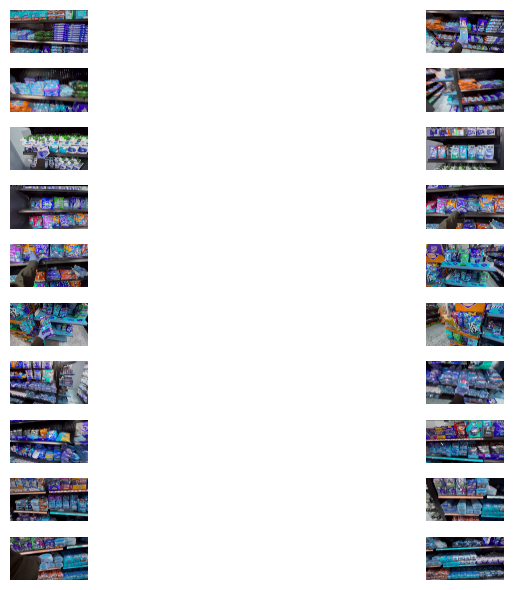

In [31]:
# Pipeline
pipeline_test = Pipeline([
    ("frames", VideoFrameAnalyzer(model_path="/kaggle/input/yolo_retrain/pytorch/default/1/yolo_retrain.pt")),
    ("subimages", Subimage_Extract()),
    ("OCR", OCR()),
    ("clip_description", CLIP_Description()),
    ("draw_clip_scene", DrawCLIPScene())
])

result_images = pipeline_test.fit_transform(["/kaggle/input/video3/video3.mp4"])
show_images(result_images)

In [32]:
def save_images(images, output_dir="output", prefix="img"):
    os.makedirs(output_dir, exist_ok=True)
    for idx, img in enumerate(images):
        filename = f"{prefix}_{idx:03d}.jpg"
        path = os.path.join(output_dir, filename)
        cv2.imwrite(path, img)
    print(f"{len(images)} imágenes guardadas en: {os.path.abspath(output_dir)}")

save_images(result_images, output_dir="/kaggle/working/outputimg", prefix="escena_clip")

20 imágenes guardadas en: /kaggle/working/outputimg
